In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
parent_dir = os.path.dirname(current_dir)
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append(os.path.abspath("../Fig_1"))
sys.path.append(os.path.abspath("../.."))
sys.path.append(parent_dir)
epidemic_dir = os.path.join(parent_dir, "Data", "2022_epidemic")
sys.path.append(epidemic_dir)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
from datetime import date,datetime, timedelta
from scipy.interpolate import CubicSpline, interp1d
import scipy.interpolate as interp
from scipy.ndimage import uniform_filter1d
from CaseDataPlotters import *
from Epidemic_trajectory_plotters import *

# Plot the data

In [2]:
# Example usage
start_date      = pd.Timestamp("2022, 5, 19")  
end_date        = pd.Timestamp("2022, 9, 15")
start_date_sim  = start_date.date()
end_date_sim    = end_date.date()
tmitig1         = pd.to_datetime('2022-06-15') 
tmitig2         = pd.to_datetime('2022-07-15') 
ts1             = 9
ts2             = 9
ts3             = 9
countries       = []
# countries += ['Germany']
countries      += ['Europe']
# countries += ['France']
# countries += ['The United Kingdom']
# countries += ['Spain']
# countries += ['Netherlands']
# countries += ['Belgium']
# countries += ['Sweden']
# countries += ['Finland']
# countries += ['Norway']
# countries += ['Ireland']
# countries += ['Portugal']
# countries += ['Italy']
# countries += ['Denmark']
# countries += ['Switzerland']
# countries += ['Luxembourg']
# countries += ['The United States']

per_capita              = True  # Set to True for per capita, False for absolute values
smooth                  = True
interpolation           = "quadratic"
window                  = 7
legendsize              = 13
#ts                      = 9

# PlotWeeklyCases(data,countries, end_date, per_capita,start_date=start_date,ylim = None,title = "Weekly cases during European epidemic",smooth=smooth,interpolation=interpolation,legendsize=legendsize)
# PlotCumulativeCases(data,countries, end_date, per_capita,start_date=start_date,smooth=smooth,interpolation=interpolation,legendsize=legendsize,ylim=None)
# PlotGrowthRate(data,countries,end_date,per_capita,tmitig1=tmitig1,tmitig2=tmitig2,ts1=ts1,ts2=ts2,ts3=ts3,start_date=start_date,ylim = (0,7),title = "Effective reproduction number in Europe",smooth=smooth,interpolation=interpolation,legendsize=legendsize)


In [3]:
import pandas as pd

# 1) Make sure your reference_date column is actually datetime
data['reference_date'] = pd.to_datetime(data['reference_date'])

# 2) Make sure your start_date is a Timestamp
#start_date = pd.Timestamp(2022, 5, 19)

# isolate Europe, sort by date
euro = (
    data[data['who_region_long'] == 'European Region']
    .sort_values('reference_date')
    .copy()
)

# add cumulative total
euro['cum_cases'] = euro['cases'].cumsum()

# now the comparison will work
row = euro[euro['reference_date'] == start_date]
if not row.empty:
    print(row['cum_cases'].iloc[0])
else:
    last = euro[euro['reference_date'] < start_date]['cum_cases']
    print(last.iloc[-1] if not last.empty else 0)
cum0 = row['cum_cases'].iloc[0] / population_sizes["Europe"]*1e6
cum0

529


0.7087352625937835

# Plot the simulation

In [4]:
N           = 170000
n_seed      = int(3*N/85000) # SCALES WITH N
#n_seed      = 3 ######!!!!!!######
ub          = 300
p           = 0.48
pexp        = 1.55
#end_date    = end_date.date()
Tvac        = None
Tmax_plot   = ((end_date_sim-start_date_sim).days)+1
k           = 2.5
name        = f"Counterfactual"
if name == "Counterfactual":
    TIS = "None"
else: 
    TIS = "sigmoid"
if pexp == 1.55:
    daily_arr       = pd.read_csv(f'daily_{name}_N={N}_p={p}_n_seed={n_seed}_t_import={start_date_sim.day}-{start_date_sim.month}_ub={ub}_TIs={TIS}.csv',header = None).to_numpy()
    Reff_arr        = pd.read_csv(f'Reff_{name}_N={N}_p={p}_n_seed={n_seed}_t_import={start_date_sim.day}-{start_date_sim.month}_ub={ub}_TIs={TIS}.csv',header = None).to_numpy()
else:
    daily_arr       = pd.read_csv(f'daily_{name}_N={N}_p={p}_pexp={pexp}_n_seed={n_seed}_t_import={start_date_sim.day}-{start_date_sim.month}_ub={ub}_TIs={TIS}.csv',header = None).to_numpy()
    Reff_arr        = pd.read_csv(f'Reff_{name}_N={N}_p={p}_pexp={pexp}_n_seed={n_seed}_t_import={start_date_sim.day}-{start_date_sim.month}_ub={ub}_TIs={TIS}.csv',header = None).to_numpy()
R_arr           = np.cumsum(daily_arr, axis=1) #Redefine to be cumulative cases
# --- Import the new Gen, Ser, and k time‐series (allowing for NaNs) ---
# Gen_arr = pd.read_csv(
#     f'Gen_{name}_N={N}_p={p}_n_seed={n_seed}_'
#     f't_import={start_date_sim.day}-{start_date_sim.month}_ub={ub}_TIs={TIS}.csv',
#     header=None
# ).to_numpy()

# Ser_arr = pd.read_csv(
#     f'Ser_{name}_N={N}_p={p}_n_seed={n_seed}_'
#     f't_import={start_date_sim.day}-{start_date_sim.month}_ub={ub}_TIs={TIS}.csv',
#     header=None
# ).to_numpy()

# k_arr = pd.read_csv(
#     f'k_{name}_N={N}_p={p}_n_seed={n_seed}_'
#     f't_import={start_date_sim.day}-{start_date_sim.month}_ub={ub}_TIs={TIS}.csv',
#     header=None
# ).to_numpy()

durations = [
    np.where(row==0)[0][0] if 0 in row else -1
    for row in Reff_arr
]
durations = np.array(durations)

for i,Reff in enumerate(Reff_arr): # Avoid "0 Reff" by extending the last value out
    Reff[durations[i]:] = Reff[durations[i]-1]
# Define a smoothing function using uniform_filter1d
def smooth(data, window_size):
    return uniform_filter1d(data, size=window_size, mode='nearest')

In [5]:
# Aggregate each row in daily_arr into weekly data, assigning the sum to the last day of each week (t=6, 13, ...)
def aggregate_to_weekly(arr):
    n_rows, n_days = arr.shape
    n_weeks = n_days // 7
    # For each row, sum every 7 days and assign to the last day of the week
    weekly_arr = np.zeros_like(arr)
    for i in range(n_rows):
        for w in range(n_weeks):
            week_sum = arr[i, w*7:(w+1)*7].sum()
            weekly_arr[i, (w+1)*7 - 1] = week_sum #Place at day 6, 13, 20 etc. (assuming day 0 is the first day reporting cases)
        # Handle any remaining days at the end (if n_days is not a multiple of 7)
        if n_days % 7 != 0:
            week_sum = arr[i, n_weeks*7:].sum()
            weekly_arr[i, -1] = week_sum
    return weekly_arr

weekly_agg_arr = aggregate_to_weekly(daily_arr)


In [6]:
pop_size    = 6e6 * N/85000 # N = 85000 corresponds to Danish MSM population (plus inactive), and 6e6 is the total Danish population
stat_style = "mean"
if stat_style   == "mean":
    mean_daily,std_daily    = compute_mean_std(daily_arr,Tmax_plot,durations=None)
    mean_R,std_R = compute_mean_std(R_arr,Tmax_plot,durations=None)
    mean_Reff,std_Reff = compute_mean_std(Reff_arr,Tmax_plot,durations=None)
    #Scale errors according to population size
    std_daily /= np.sqrt(len(daily_arr))
    std_R /= np.sqrt(len(daily_arr))
    std_Reff /= np.sqrt(len(daily_arr))
    lower_daily, upper_daily = compute_bounds(mean_daily,std_daily)
    lower_R, upper_R = compute_bounds(mean_R,std_R)
    lower_Reff, upper_Reff = compute_bounds(mean_Reff,std_Reff)
    # Gen
    # mean_Gen = np.nanmean(Gen_arr[:,:Tmax_plot], axis=0)
    # std_Gen  = np.nanstd(Gen_arr[:,:Tmax_plot],  axis=0)
    # lower_Gen = mean_Gen - 1.96 * std_Gen / np.sqrt(np.sum(~np.isnan(Gen_arr[:,:Tmax_plot]), axis=0))
    # upper_Gen = mean_Gen + 1.96 * std_Gen / np.sqrt(np.sum(~np.isnan(Gen_arr[:,:Tmax_plot]), axis=0))

    # # Ser
    # mean_Ser = np.nanmean(Ser_arr, axis=0)
    # std_Ser  = np.nanstd(Ser_arr,  axis=0)
    # lower_Ser = mean_Ser - 1.96 * std_Ser / np.sqrt(np.sum(~np.isnan(Ser_arr), axis=0))
    # upper_Ser = mean_Ser + 1.96 * std_Ser / np.sqrt(np.sum(~np.isnan(Ser_arr), axis=0))

    # # k
    # mean_k_arr = np.nanmean(k_arr, axis=0)
    # std_k_arr  = np.nanstd(k_arr,  axis=0)
    # lower_k = mean_k_arr - 1.96 * std_k_arr / np.sqrt(np.sum(~np.isnan(k_arr), axis=0))
    # upper_k = mean_k_arr + 1.96 * std_k_arr / np.sqrt(np.sum(~np.isnan(k_arr), axis=0))

    print(f"Ratio between European MSM and simulated population = {population_sizes["Europe"]/pop_size}")
elif stat_style == "median":
    mean_daily,lower_daily,upper_daily    = compute_median_quantiles(daily_arr,Tmax_plot,durations=None) 
    mean_R,lower_R,upper_R = compute_median_quantiles(R_arr,Tmax_plot,durations=None)
    mean_Reff,lower_Reff,upper_Reff = compute_median_quantiles(Reff_arr,Tmax_plot,durations=None)
    _,bottom_daily,top_daily    = compute_median_quantiles(daily_arr,Tmax_plot,quantiles = (0.05,0.95),durations=None) 
    _,bottom_R,top_R = compute_median_quantiles(R_arr,Tmax_plot,quantiles=(0.05,0.95), durations=None)
    _,bottom_Reff,top_Reff = compute_median_quantiles(Reff_arr,Tmax_plot, quantiles=(0.05,0.95),durations=None)
print(f"Number of runs = {len(daily_arr)}")

Ratio between European MSM and simulated population = 62.2
Number of runs = 62


In [7]:
# Apply smoothing
window_size = 7
mean_daily_smooth, lower_daily_smooth, upper_daily_smooth = smooth_data(mean_daily,lower_daily,upper_daily,window_size)
mean_R_smooth, lower_R_smooth, upper_R_smooth = smooth_data(mean_R,lower_R,upper_R,window_size)
mean_Reff_smooth, lower_Reff_smooth, upper_Reff_smooth = smooth_data(mean_Reff,lower_Reff,upper_Reff,window_size)
if stat_style == "median":
    bottom_daily_smooth = smooth(bottom_daily,window_size)
    top_daily_smooth = smooth(top_daily,window_size)
    bottom_R_smooth = smooth(bottom_R,window_size)
    top_R_smooth = smooth(top_R,window_size)
    bottom_Reff_smooth = smooth(bottom_Reff,window_size)
    top_Reff_smooth = smooth(top_Reff,window_size)
# Create a date range starting from May 1st, 2022
start_date = start_date_sim
dates = [start_date + timedelta(days=i) for i in range(Tmax_plot)]

# Formatter for the date axis
date_format = mdates.DateFormatter('%b %d')

# Define x-axis limits
xlim_start = start_date
xlim_end = dates[-1]

per_million = True
factor      = pop_size/1e6 if per_million else 1

#Convert to weekly
mean_weekly_smooth = mean_daily_smooth*7
lower_weekly_smooth = lower_daily_smooth*7
upper_weekly_smooth = upper_daily_smooth*7
#bottom_weekly_smooth = bottom_daily_smooth*7
#top_weekly_smooth = top_daily_smooth*7


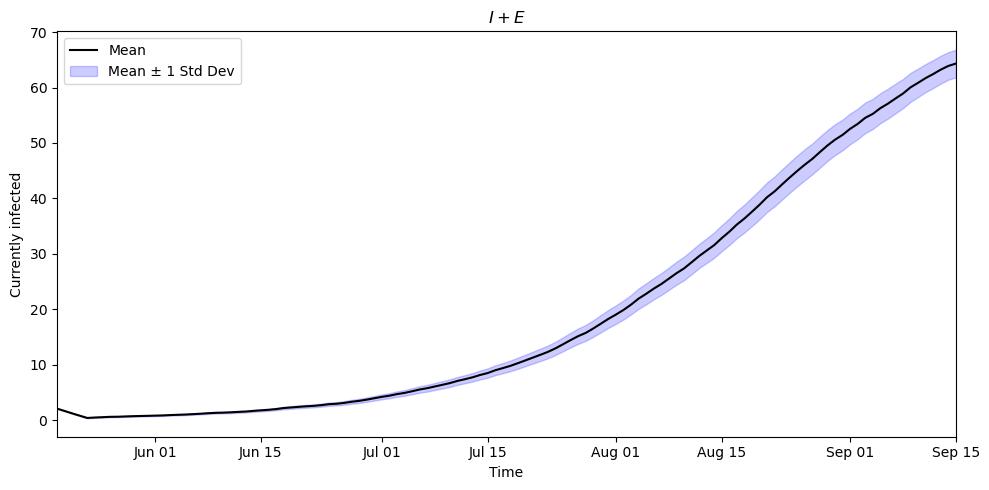

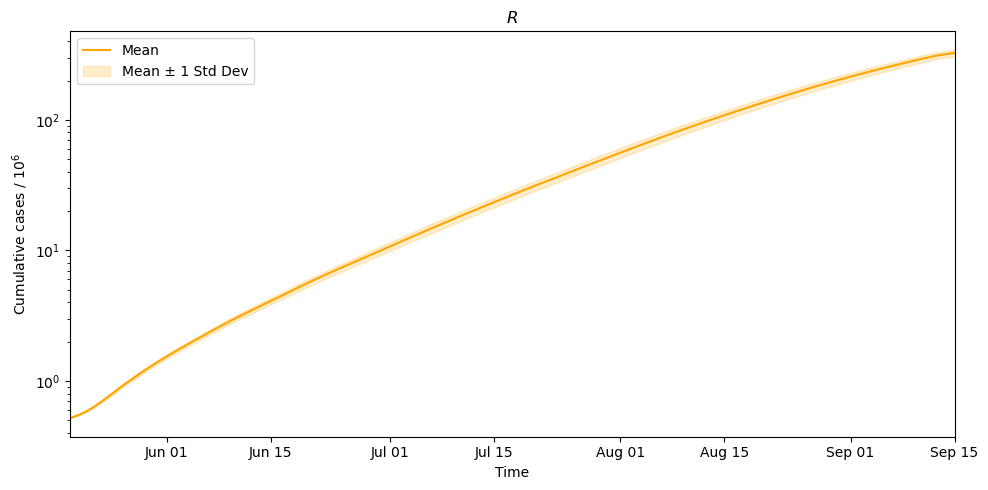

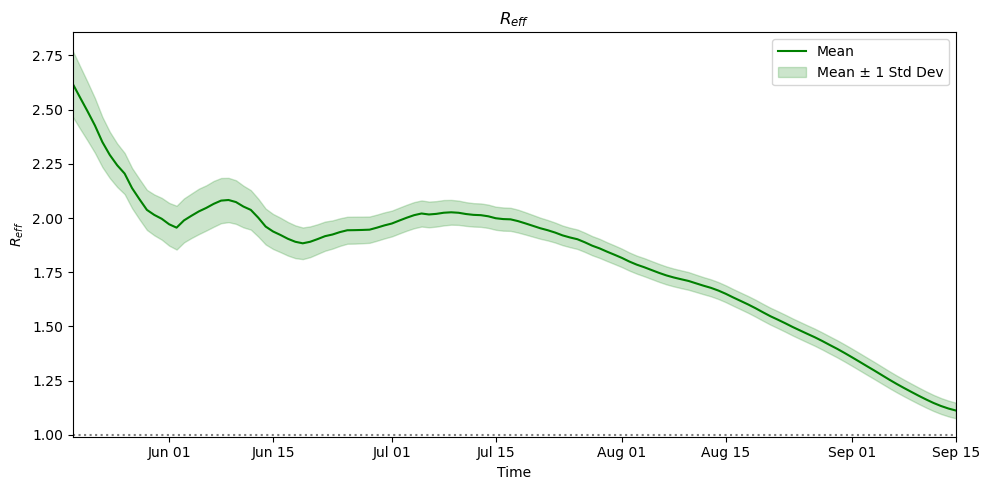

In [8]:
plot_IE(dates,mean_weekly_smooth,lower_weekly_smooth,upper_weekly_smooth,xlim_start, xlim_end, factor, date_format)
plot_R(dates, mean_R_smooth, lower_R_smooth, upper_R_smooth, xlim_start, xlim_end, factor, date_format, per_million,yscale="log")
plot_Reff(dates, mean_Reff_smooth, lower_Reff_smooth, upper_Reff_smooth, xlim_start, xlim_end, date_format,yscale="linear")

# Combine both

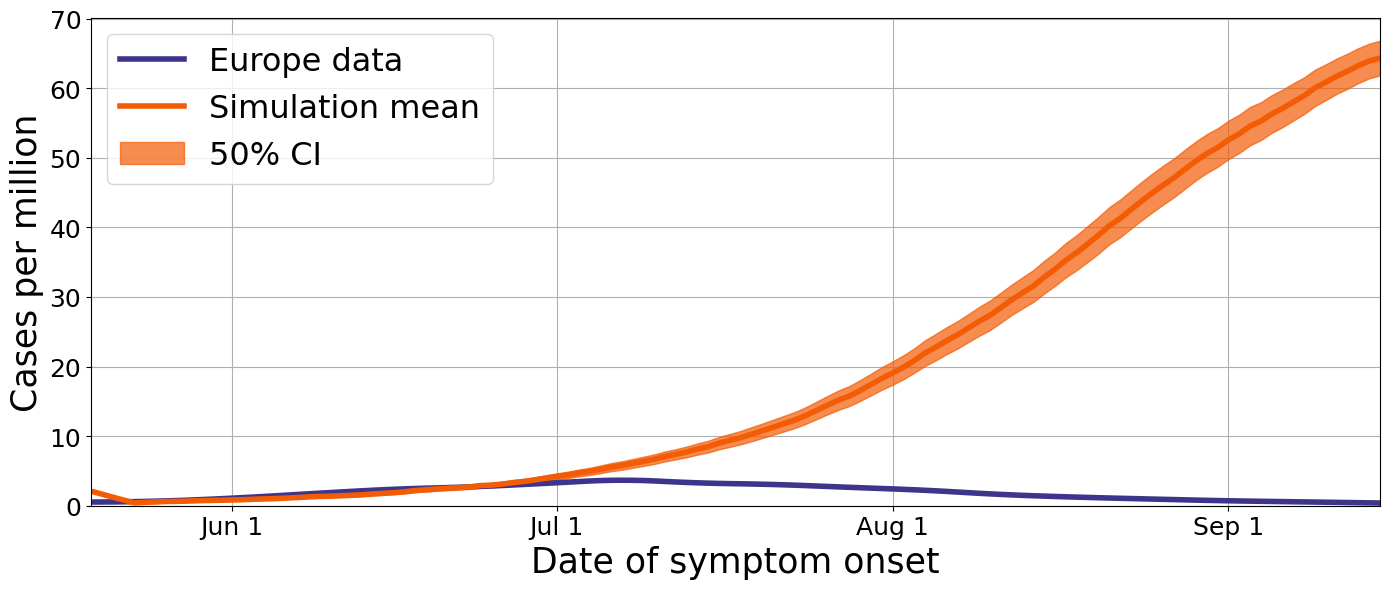

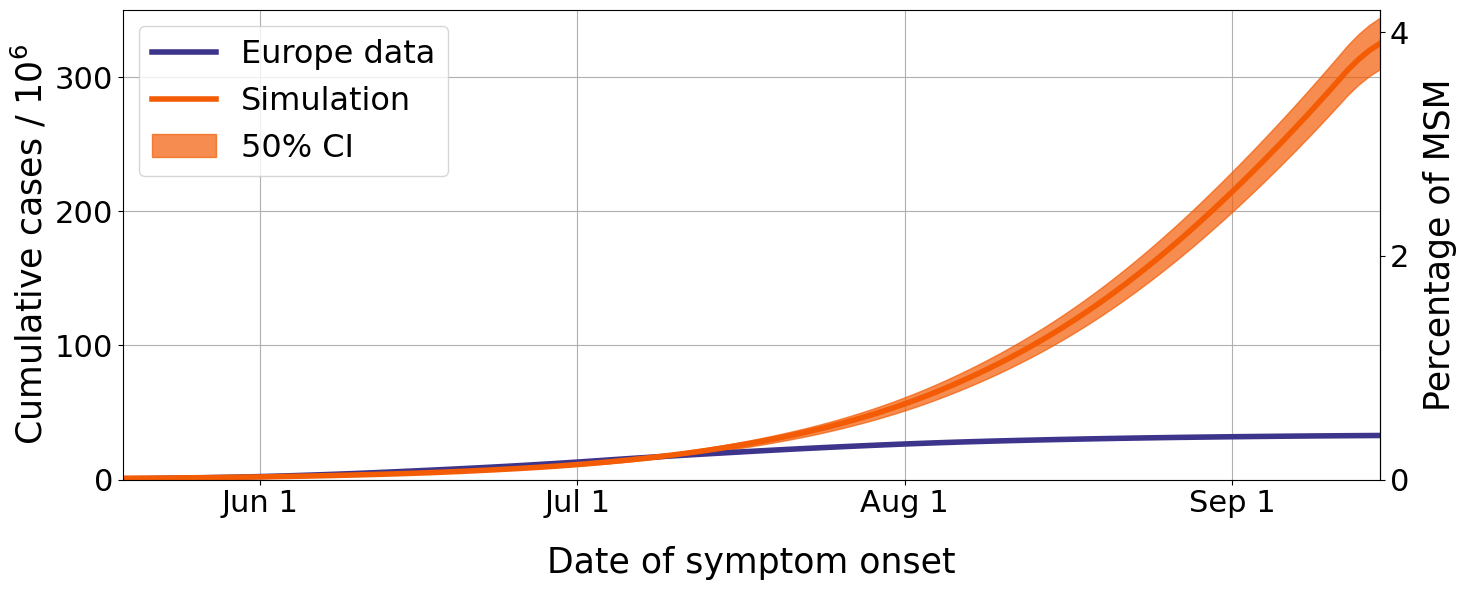

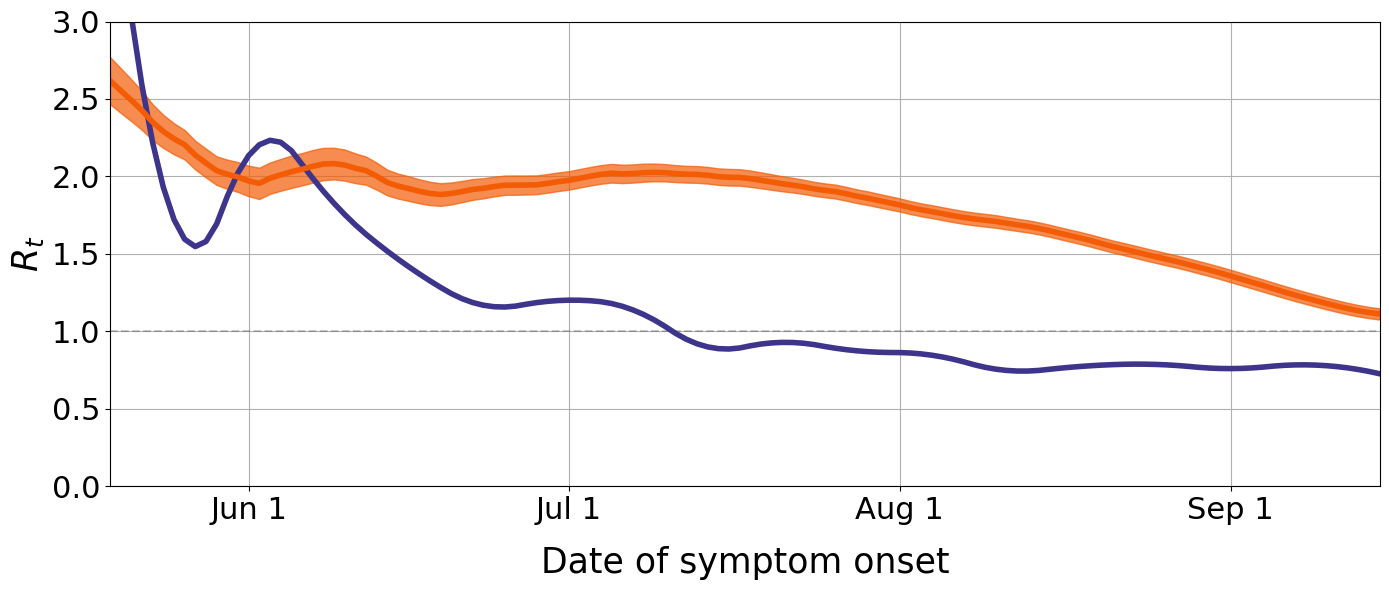

In [9]:
start_date  = pd.Timestamp(start_date)
end_date    = pd.Timestamp(end_date)
t0_date     = pd.Timestamp("2022, 6, 6")
ts_array    = generate_sigmoid_series(start_date,end_date,t0_date,k/30.5)
# Nvac        = 100/factor
# durVac      = 35 
ticksize    = 18
xticksize   = 22
yticksize   = 22
legendsize  = 23
labelsize   = 25
figsize     = (14,6)


PlotWeeklyCasesWithSimulation(
    data=data, 
    countries=countries, 
    end_date=end_date, 
    per_capita=per_capita, 
    start_date=start_date, 
    #special_country='Europe', 
    smooth=smooth, 
    interpolation=interpolation, 
    simulation_dates=dates, 
    mean_IE_smooth=mean_weekly_smooth, 
    lower_IE_smooth=lower_weekly_smooth, 
    upper_IE_smooth=upper_weekly_smooth,
    lower2_IE_smooth=bottom_weekly_smooth if stat_style == "median" else None, 
    upper2_IE_smooth=top_weekly_smooth if stat_style == "median" else None, 
    factor=factor,
    yscale = "linear",
    title="",
    linewidth=4,
    labelsize=labelsize,
    xticksize=ticksize,
    yticksize=ticksize,
    legendsize=legendsize, 
    figsize = figsize,
    rotation = 0,
    # Tvac=vac_date,
    # Nvac=Nvac,
    # durVac=durVac
)

cumscale = "linear"
PlotCumulativeCasesWithSimulation(
    data=data, 
    countries=countries, 
    end_date=end_date, 
    per_capita=per_capita, 
    start_date=start_date, 
    cum0 = cum0-0.3,
    smooth=smooth, 
    interpolation=interpolation, 
    simulation_dates=dates, 
    mean_R_smooth=mean_R_smooth, 
    lower_R_smooth=lower_R_smooth, 
    upper_R_smooth=upper_R_smooth,
    lower2_R_smooth=bottom_R_smooth if stat_style == "median" else None, 
    upper2_R_smooth=top_R_smooth if stat_style == "median" else None,
    factor=factor,
    ylim=(0,350) if cumscale == "linear" else (4e-1,1e2),
    yscale = cumscale,
    linewidth = 4,
    labelsize=labelsize,
    legendsize=legendsize, 
    yticksize=yticksize,
    xticksize=xticksize,
    rotation = 0,
    figsize=figsize,
    y1multiple = 100,
    y2multiple = 2,
    #Tvac=vac_date,
    #Nvac=Nvac,
    #durVac=durVac
)

PlotGrowthRateWithSimulation(
    data=data, 
    countries=countries, 
    end_date=end_date, 
    per_capita=per_capita, 
    start_date=start_date, 
    smooth=smooth, 
    interpolation=interpolation, 
    legendsize=0, 
    simulation_dates=dates, 
    mean_Reff_smooth=mean_Reff_smooth, 
    lower_Reff_smooth=lower_Reff_smooth, 
    upper_Reff_smooth=upper_Reff_smooth,
    lower2_Reff_smooth=bottom_Reff_smooth if stat_style == "median" else None, 
    upper2_Reff_smooth=top_Reff_smooth if stat_style == "median" else None,
    ylim=(0,3),
    ts_series=ts_array,
    title="",
    linewidth=4,
    labelsize=labelsize,
    xticksize=xticksize,
    yticksize=yticksize,
    rotation = 0,
    figsize = figsize
)